# Home Credit Default Risk

## 1. Introduction

This is a binary Classification task: we want to predict whether the person applying for a home credit will be able to repay their debt or not. Our model will have to predict a 1 indicating the client will have payment difficulties: he/she will have late payment of more than X days on at least one of the first Y installments of the loan in our sample, 0 in all other cases.

The dataset is composed of multiple files with different information about loans taken. In this project, we will work exclusively with the primary files: `application_train_aai.csv` and `application_test_aai.csv`.

We will use [Area Under the ROC Curve](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc?hl=es_419) as the evaluation metric, so our models will have to return the probabilities that a loan is not paid for each row.

In [1]:
# Import libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.validation import check_is_fitted

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src import config, data_utils, preprocessing

### Getting the data

To access the data for this project, you only need to execute the code below. This will download three files inside the `dataset` folder:

- `application_train_aai.csv`: Training dataset you must use to train and find the best hyperparameters on your model.

- `application_test_aai.csv`: Test dataset without labels. Because of the absence of labels, you can't use this dataset for your experiments. You will use the file only at the end after you choose what you think is the best model for the tasks. You will have to use that model to fill values in the `TARGET` column using the model predictions.

- `HomeCredit_columns_description.csv`: This file contains descriptions for the columns in train and test datasets.


1.1. Load the training and test datasets. Also, the auxiliary file `HomeCredit_columns_description.csv` has additional information about the features in the dataset.

In [2]:
app_train, app_test, columns_description = data_utils.get_datasets()


if app_train.shape == (246008, 122):
    print("Success: app_train shape is correct!")
else:
    raise ValueError("Train dataset shape is incorrect, please review your code")

if isinstance(app_train, pd.DataFrame):
    print("Success: app_train type is correct!")
else:
    raise ValueError("Train dataset type is incorrect, please review your code")

if app_test.shape == (61503, 122):
    print("Success: app_test shape is correct!")
else:
    raise ValueError("Test dataset shape is incorrect, please review your code")

if isinstance(app_test, pd.DataFrame):
    print("Success: app_test type is correct!")
else:
    raise ValueError("Test dataset type is incorrect, please review your code")

Success: app_train shape is correct!
Success: app_train type is correct!
Success: app_test shape is correct!
Success: app_test type is correct!


### Exploratory Data Analysis

A lot of the analysis of the data can be found on publicly available Kaggle kernels or blog posts, but you need to make sure you understand the dataset's properties before starting working on it, so we'll do exploratory data analysis for the main files.

#### Dataset Basics

1.2. Print how many samples do we have in our train and test datasets.

In [3]:
# Load the datasets
train_df = pd.read_csv('./dataset/application_train_aai.csv')
test_df = pd.read_csv('./dataset/application_test_aai.csv')

# Show the number of samples
print(f'Number of samples in train dataset: {train_df.shape[0]}')
print(f'Number of samples in test dataset: {test_df.shape[0]}')

Number of samples in train dataset: 246008
Number of samples in test dataset: 61503


1.3. List all columns in the train dataset.

In [5]:
# Show all the names of the columns of the train dataset
print(train_df.columns.tolist())

['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELE

1.4. Show the first 5 records of the training dataset, transpose the dataframe to see each record as a column and features as rows, make sure all features are visualized. Take your time to review what kind of information you can gather from this data.

For reference only, it should look like this:

|0|1|2|3|4
|---|---|---|---|---
Unnamed: 0|187399|84777|268140|270686|33785
SK_ID_CURR|317244|198357|410700|413785|139141
TARGET|0|0|0|0|0
NAME_CONTRACT_TYPE|Cash loans|Cash loans|Cash loans|Cash loans|Cash loans
...|...|...|...|...|...
AMT_REQ_CREDIT_BUREAU_DAY|0.0|0.0|0.0|0.0|0.0

In [6]:
# Show the first 5 records transposed
train_df.head().T

,0,1,2,3,4
SK_ID_CURR,428247,140966,407283,434300,446788
TARGET,0,0,0,0,0
NAME_CONTRACT_TYPE,Cash loans,Cash loans,Revolving loans,Cash loans,Cash loans
CODE_GENDER,F,M,F,F,F
FLAG_OWN_CAR,N,Y,N,N,N
...,...,...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,NaN,0.0,0.0,0.0,0.0
AMT_REQ_CREDIT_BUREAU_WEEK,NaN,0.0,0.0,0.0,0.0
AMT_REQ_CREDIT_BUREAU_MON,NaN,0.0,0.0,0.0,0.0
AMT_REQ_CREDIT_BUREAU_QRT,NaN,0.0,0.0,1.0,0.0


1.5. Show the distribution of the target variable values: print the total value count and the percentage of each value, plot this relationship.

Absolute counting of values of TARGET:
 0    226257
1     19751
Name: TARGET, dtype: int64

Percentage of values of TARGET:
 0    91.97
1     8.03
Name: TARGET, dtype: float64


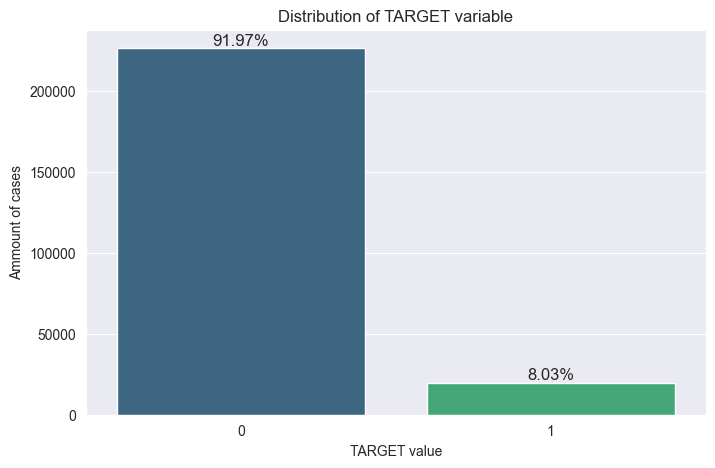

In [7]:
# Absolute counting of values in the TARGET variable
target_count = train_df['TARGET'].value_counts()

# Percentage of each value
target_percentage = train_df['TARGET'].value_counts(normalize=True) * 100

# Print both values
print("Absolute counting of values of TARGET:\n", target_count)
print("\nPercentage of values of TARGET:\n", round(target_percentage, 2))

# Visualize the distribution in a graph
plt.figure(figsize=(8, 5))
sns.barplot(x=target_count.index, y=target_count.values, palette="viridis")

plt.title('Distribution of TARGET variable')
plt.xlabel('TARGET value')
plt.ylabel('Ammount of cases')

# Show percentage on each bar
for index, value in enumerate(target_count.values):
    plt.text(index, value, f'{target_percentage.values[index]:.2f}%', ha='center', va='bottom', fontsize=12)

plt.show()

1.6. Show the number of columns of each data type.

In [9]:
# Count of the number of columns per each data type
dtype_counts = train_df.dtypes.value_counts()

# Show result
print("Number of columns per data type:")
print(dtype_counts)

Number of columns per data type:
float64    65
int64      41
object     16
dtype: int64


1.7. For categorical variables (`object` data type), show the number of distinct values in each column (number of labels).

In [10]:
# Select categorical columns
categorical_columns = train_df.select_dtypes(include=['object'])

# Show ammount of unique values on each categorical column
unique_values = categorical_columns.nunique().sort_values(ascending=False)

print("Number of unique values per categorical column:")
print(unique_values)

Number of unique values per categorical column:
ORGANIZATION_TYPE             58
OCCUPATION_TYPE               18
NAME_INCOME_TYPE               8
NAME_TYPE_SUITE                7
WEEKDAY_APPR_PROCESS_START     7
WALLSMATERIAL_MODE             7
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
NAME_EDUCATION_TYPE            5
FONDKAPREMONT_MODE             4
CODE_GENDER                    3
HOUSETYPE_MODE                 3
NAME_CONTRACT_TYPE             2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
EMERGENCYSTATE_MODE            2
dtype: int64


1.8. Analyzing missing data: show the percentage of missing data for each column ordered by percentage descending (show only the 20 columns with higher missing pct)

In [11]:
missing_percentage = (train_df.isnull().mean() * 100).sort_values(ascending=False).head(20)

# Show results
print("Top 20 columns with highest missing data percentage:")
print(missing_percentage)

Top 20 columns with highest missing data percentage:
COMMONAREA_MEDI             69.993252
COMMONAREA_AVG              69.993252
COMMONAREA_MODE             69.993252
NONLIVINGAPARTMENTS_MODE    69.548958
NONLIVINGAPARTMENTS_AVG     69.548958
NONLIVINGAPARTMENTS_MEDI    69.548958
FONDKAPREMONT_MODE          68.518503
LIVINGAPARTMENTS_MODE       68.491269
LIVINGAPARTMENTS_AVG        68.491269
LIVINGAPARTMENTS_MEDI       68.491269
FLOORSMIN_AVG               67.987626
FLOORSMIN_MODE              67.987626
FLOORSMIN_MEDI              67.987626
YEARS_BUILD_MEDI            66.656369
YEARS_BUILD_MODE            66.656369
YEARS_BUILD_AVG             66.656369
OWN_CAR_AGE                 66.055982
LANDAREA_MEDI               59.524893
LANDAREA_MODE               59.524893
LANDAREA_AVG                59.524893
dtype: float64


#### Analyzing distribution of variables

1.9. Show the distribution of credit amounts.

Descriptive statistics for AMT_CREDIT:
count    2.460080e+05
mean     5.991707e+05
std      4.034845e+05
min      4.500000e+04
25%      2.700000e+05
50%      5.124465e+05
75%      8.086500e+05
max      4.050000e+06
Name: AMT_CREDIT, dtype: float64


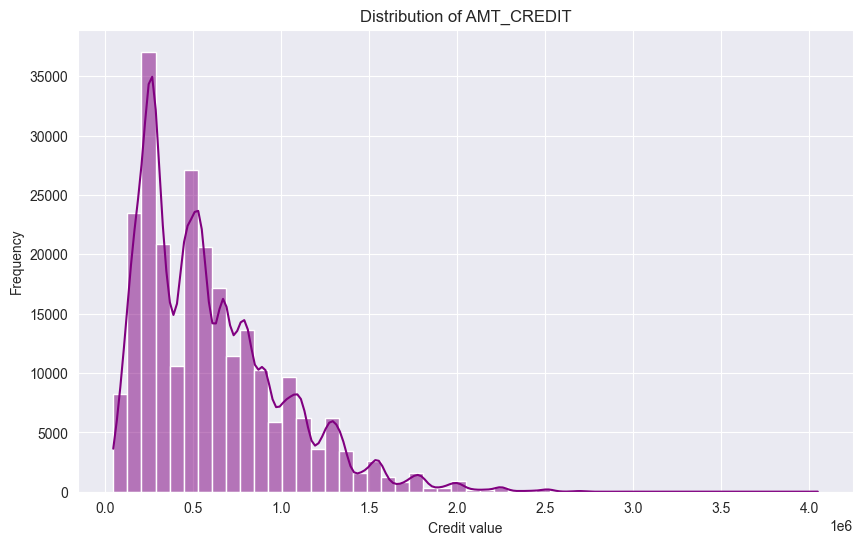

In [12]:
# Basic descriptive statistics
print("Descriptive statistics for AMT_CREDIT:")
print(train_df['AMT_CREDIT'].describe())

# Distribution graphic
plt.figure(figsize=(10, 6))
sns.histplot(train_df['AMT_CREDIT'], kde=True, bins=50, color='purple')

# Title and labels of the graph
plt.title('Distribution of AMT_CREDIT')
plt.xlabel('Credit value')
plt.ylabel('Frequency')

plt.show()

1.10. Plot the education level of the credit applicants, show the percentages of each category. Also print the total counts for each category.

Total ammount for each educative level:
Secondary / secondary special    174657
Higher education                  59990
Incomplete higher                  8248
Lower secondary                    2984
Academic degree                     129
Name: NAME_EDUCATION_TYPE, dtype: int64


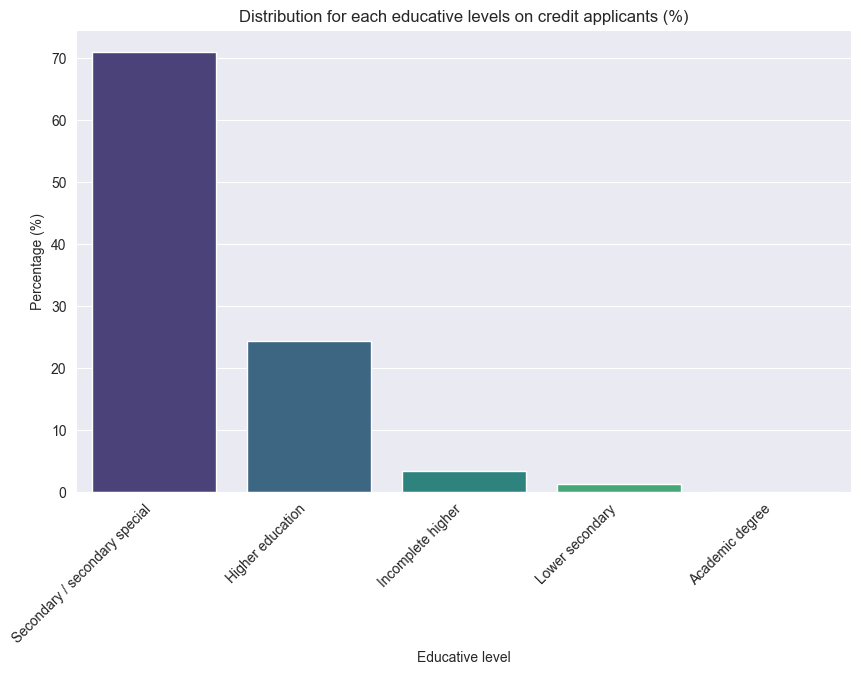

In [13]:
# Total count for each educative category
education_counts = train_df['NAME_EDUCATION_TYPE'].value_counts()

# Percentage for each educative category
education_percentages = train_df['NAME_EDUCATION_TYPE'].value_counts(normalize=True) * 100

# Show total count of each category
print("Total ammount for each educative level:")
print(education_counts)

# Porcentual bars graph
plt.figure(figsize=(10, 6))
sns.barplot(x=education_percentages.index, y=education_percentages, palette="viridis")

# Labels and title
plt.title('Distribution for each educative levels on credit applicants (%)')
plt.xlabel('Educative level')
plt.ylabel('Percentage (%)')

plt.xticks(rotation=45, ha='right')

plt.show()

1.11. Plot the distribution of occupation of the loan applicants.

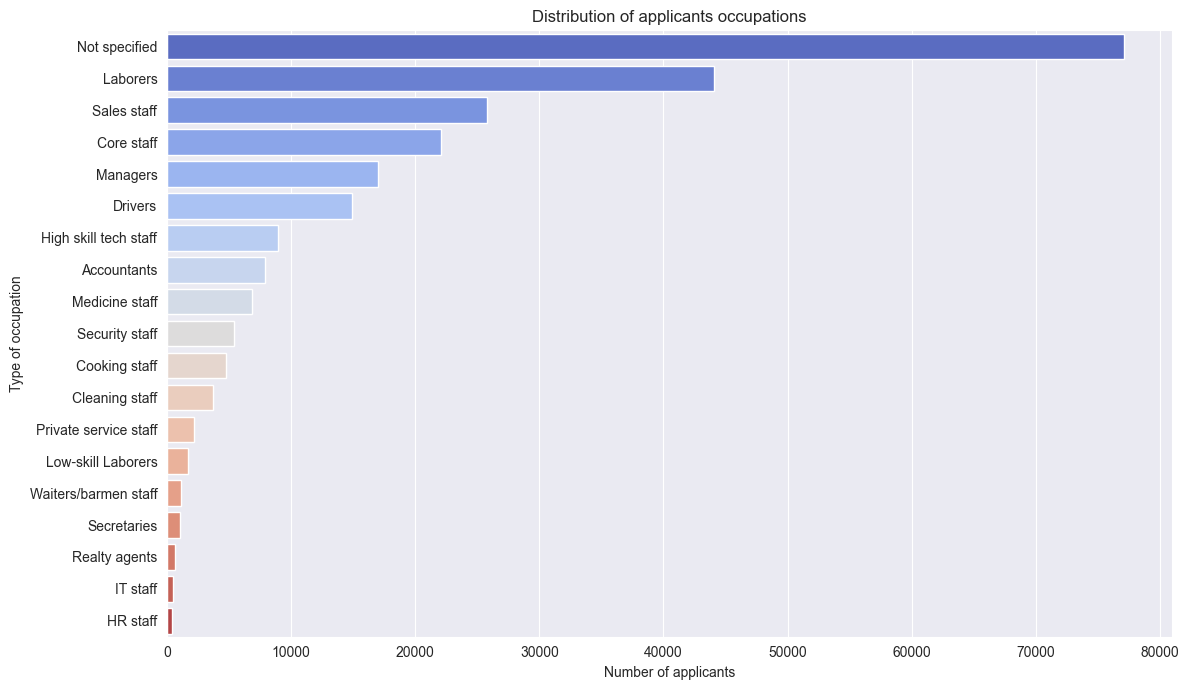

In [14]:
# Occupancy count including missing values
occupation_counts = train_df['OCCUPATION_TYPE'].fillna('Not specified').value_counts()

# Bar chart for the distribution of occupations
plt.figure(figsize=(12, 7))
sns.barplot(y=occupation_counts.index, x=occupation_counts.values, palette='coolwarm')

# Chart title and labels
plt.title('Distribution of applicants occupations')
plt.xlabel('Number of applicants')
plt.ylabel('Type of occupation')

plt.tight_layout()
plt.show()

1.12. Plot the family status of the applicants.

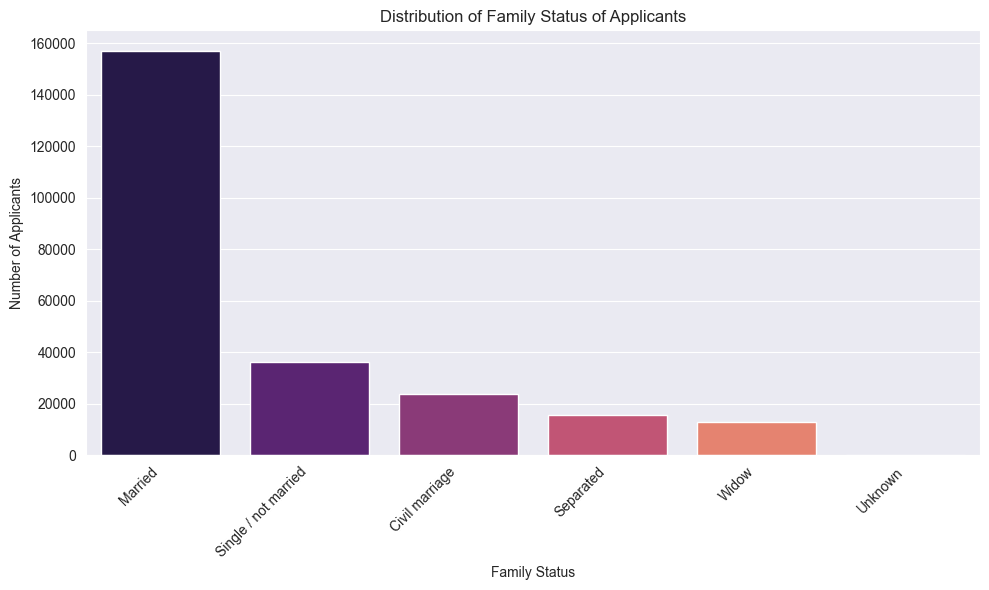

In [4]:
# Counting of family status of applicants
family_status_counts = train_df['NAME_FAMILY_STATUS'].value_counts()

# Bar chart to show distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=family_status_counts.index, y=family_status_counts.values, palette='magma')

# Title and labels
plt.title('Distribution of Family Status of Applicants')
plt.xlabel('Family Status')
plt.ylabel('Number of Applicants')

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

1.13. Plot the income type of applicants grouped by the target variable.

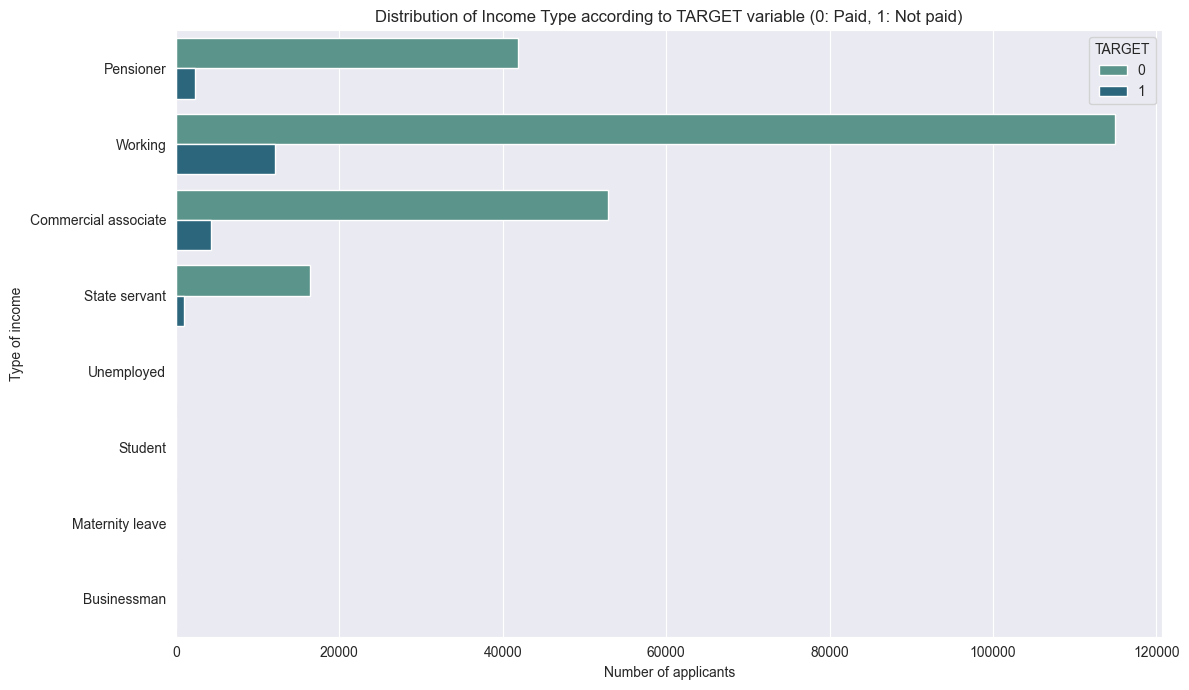

In [5]:
plt.figure(figsize=(12, 7))
sns.countplot(data=train_df, y='NAME_INCOME_TYPE', hue='TARGET', palette='crest')

# Title and labels
plt.title('Distribution of Income Type according to TARGET variable (0: Paid, 1: Not paid)')
plt.xlabel('Number of applicants')
plt.ylabel('Type of income')

plt.tight_layout()
plt.show()

## 2. Preprocessing

2.1. The next step will be to separate our train and test datasets columns between Features (the input to the model) and Targets (what the model has to predict with the given features).

- Assign to `X_train` all the columns from `app_train` that should be used as features for training our models.
- Assign to `y_train` the single column from `app_train` that should be used as our target (i.e. what we want to predict).
- Assign to `X_test` all the columns from `app_test` that should be used as features for training our models.
- Assign to `y_test` the single column from `app_test` that should be used as our target (i.e. what we want to predict).

In [4]:
# Now we execute the function above to get the result
X_train, y_train, X_test, y_test = data_utils.get_feature_target(app_train, app_test)


if X_train.shape == (246008, 121):
    print("Success: X_train shape is correct!")
else:
    raise ValueError("X_train dataset shape is incorrect, please review your code")

if isinstance(X_train, pd.DataFrame):
    print("Success: X_train type is correct!")
else:
    raise ValueError("Train dataset type is incorrect, please review your code")

if y_train.shape == (246008,) or y_train.shape == (246008, 1):
    print("Success: y_train shape is correct!")
else:
    raise ValueError("Train labels shape is incorrect, please review your code")

if X_test.shape == (61503, 121):
    print("Success: X_test shape is correct!")
else:
    raise ValueError("Test dataset shape is incorrect, please review your code")

if isinstance(X_test, pd.DataFrame):
    print("Success: X_test type is correct!")
else:
    raise ValueError("Test dataset type is incorrect, please review your code")

if y_test.shape == (61503,) or y_test.shape == (61503, 1):
    print("Success: y_test shape is correct!")
else:
    raise ValueError("Test labels shape is incorrect, please review your code")

Success: X_train shape is correct!
Success: X_train type is correct!
Success: y_train shape is correct!
Success: X_test shape is correct!
Success: X_test type is correct!
Success: y_test shape is correct!


2.2. In order to avoid overfitting while searching for the best model hyperparameters, it's always a good idea to split our training dataset into two new sets called `train` and `validation`. 

While the `train` data will be used to fit the model and adjust its internal weights, the `validation` will be exclusively used to test the model performance on unseen data during training, it's like a testing dataset used during experimentation.

Remember we can't use the `test` dataset to validate the model performance because this one lacks of labels :( So the `validation` data will be the only resource you will have to evaluate the final model performance.


In [5]:
# Now we execute the function above to get the result
X_train, X_val, y_train, y_val = data_utils.get_train_val_sets(X_train, y_train)


if X_train.shape == (196806, 121):
    print("Success: X_train shape is correct!")
else:
    raise ValueError("X_train dataset shape is incorrect, please review your code")

if isinstance(X_train, pd.DataFrame):
    print("Success: X_train type is correct!")
else:
    raise ValueError("Train dataset type is incorrect, please review your code")

if y_train.shape == (196806,) or y_train.shape == (196806, 1):
    print("Success: y_train shape is correct!")
else:
    raise ValueError("Train labels shape is incorrect, please review your code")

if X_val.shape == (49202, 121):
    print("Success: X_test shape is correct!")
else:
    raise ValueError("Test dataset shape is incorrect, please review your code")

if isinstance(X_val, pd.DataFrame):
    print("Success: X_test type is correct!")
else:
    raise ValueError("Test dataset type is incorrect, please review your code")

if y_val.shape == (49202,) or y_val.shape == (49202, 1):
    print("Success: y_test shape is correct!")
else:
    raise ValueError("Test labels shape is incorrect, please review your code")

Success: X_train shape is correct!
Success: X_train type is correct!
Success: y_train shape is correct!
Success: X_test shape is correct!
Success: X_test type is correct!
Success: y_test shape is correct!


2.3. In the following cell, we are going to execute the preprocessing function.

**Important Note:** From now on, you must always use `train_data` for training your models and `val_data` only for the final evaluation of the model trained.


In [6]:
train_data, val_data, test_data = preprocessing.preprocess_data(X_train, X_val, X_test)


if train_data.shape == (196806, 246):
    print("Success: train_data shape is correct!")
else:
    raise ValueError("train_data dataset shape is incorrect, please review your code")

if isinstance(train_data, np.ndarray):
    print("Success: train_data type is correct!")
else:
    raise ValueError("Train dataset type is incorrect, please review your code")

if val_data.shape == (49202, 246):
    print("Success: val_data shape is correct!")
else:
    raise ValueError("val_data dataset shape is incorrect, please review your code")

if isinstance(val_data, np.ndarray):
    print("Success: val_data type is correct!")
else:
    raise ValueError("Validation dataset type is incorrect, please review your code")

if test_data.shape == (61503, 246):
    print("Success: test_data shape is correct!")
else:
    raise ValueError("test_data dataset shape is incorrect, please review your code")

if isinstance(test_data, np.ndarray):
    print("Success: test_data type is correct!")
else:
    raise ValueError("Test dataset type is incorrect, please review your code")

Input train data shape:  (196806, 121)
Input val data shape:  (49202, 121)
Input test data shape:  (61503, 121) 



C:\Users\joaco\Desktop\AnyoneAI\Sprint Project 02\assignment\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Success: train_data shape is correct!
Success: train_data type is correct!
Success: val_data shape is correct!
Success: val_data type is correct!
Success: test_data shape is correct!
Success: test_data type is correct!


## 3. Training Models

As usual, you will start training simple models and will progressively move to more complex models and pipelines.

**Pro tip:** It is of utmost importance to make an accurate estimation of the time required to train a machine learning model. Because of this, we recommend you to use Python [time](https://docs.python.org/3/library/time.html) library or Jupyter magic function `%%time` on the cell you're training your model to get an estimate of the time it took to fit your data.

### Baseline: LogisticRegression

3.1. Import LogisticRegression from sklearn and train a model using the preprocesed train data from the previous section, and just default parameters. If you receive a warning because the algorithm failed to converge, try increasing the number of iterations or decreasing the C parameter.

Assign the trained model to `log_reg` variable.

In [7]:
%%time

# This is an example code on how to:
#   - Create and fit (train) a logistic regression
#   - Assign to `log_reg` variable
log_reg = None
log_reg = LogisticRegression(C=0.0001)
log_reg.fit(train_data, y_train)

CPU times: total: 6.61 s
Wall time: 1.5 s


LogisticRegression(C=0.0001)

In [8]:
if isinstance(log_reg, LogisticRegression):
    print("Success: Logistic regression model type is correct!")
else:
    raise ValueError(
        "Logistic regression model type is incorrect, please review your code"
    )

check_is_fitted(log_reg)

Success: Logistic regression model type is correct!


3.2. Use the trained model to predict probabilities for `train_data` and `val_data`.

**Important note:** When using the function `predict_proba()` for getting model probabilities you will get, for each sample, a tuple indicating the probability for class 0 and for class 1 respectively. For computing the AUC ROC score we only need the probability that the debt is not repaid (equivalent to class 1). As an example, the result from running `predict_proba()` on validation dataset will have a shape of `(49202, 2)` but, we only need the second column from that matrix, which corresponds to the class 1.


In [9]:
# Train data predictions (class 1)
log_reg_train = log_reg.predict_proba(train_data)[:, 1]

# Validation data predictions (class 1)
log_reg_val = log_reg.predict_proba(val_data)[:, 1]

3.3. Get AUC ROC score on train and validation datasets. See [scikit-learn AUC ROC function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) for a working implementation.

Assign the AUC ROC score to `lr_roc_auc` variable.


In [10]:
# Train ROC AUC Score
roc_auc_train = roc_auc_score(y_true=y_train, y_score=log_reg_train)
print(f"Train ROC AUC Score: {roc_auc_train:.4f}")

# Validation ROC AUC Score
roc_auc_val = roc_auc_score(y_true=y_val, y_score=log_reg_val)
print(f"Validation ROC AUC Score: {roc_auc_val:.4f}")

Train ROC AUC Score: 0.6798
Validation ROC AUC Score: 0.6772


At this point, the model should produce a result of around 0.67.

The model is not overfitting or underfitting, because its predictive performance is suboptimal.

In [11]:
if isinstance(roc_auc_val, float):
    print("Success: AUC ROC score type is correct!")
else:
    raise ValueError("AUC ROC score type is incorrect, please review your code")

if roc_auc_val >= 0.6:
    print("Success: AUC ROC score is correct!")
else:
    raise ValueError("AUC ROC score is incorrect, please review your code")

Success: AUC ROC score type is correct!
Success: AUC ROC score is correct!


### Training a Random Forest Classifier

3.4. Train a RandomForestClassifier, print the time taken by the fit function. Just use default hyperparameters, except for `n_jobs`, which should be set to "-1" to allow the library to use all CPU cores to speed up training time.

In [12]:
%%time

rf = RandomForestClassifier(n_jobs=-1)
rf.fit(train_data, y_train)

CPU times: total: 3min 28s
Wall time: 28.4 s


RandomForestClassifier(n_jobs=-1)

In [13]:
if isinstance(rf, RandomForestClassifier):
    print("Success: RandomForestClassifier model type is correct!")
else:
    raise ValueError(
        "RandomForestClassifier model type is incorrect, please review your code"
    )

check_is_fitted(rf)

Success: RandomForestClassifier model type is correct!


3.5. Use the classifier to predict probabilities for `train_data` and `val_data`.

In [14]:
# Train data predictions (class 1)
rf_pred_train = rf.predict_proba(train_data)[:, 1]

# Validation data predictions (class 1)
rf_pred_val = rf.predict_proba(val_data)[:, 1]

3.6. Get AUC ROC score on train and validation datasets.


In [15]:
# Train ROC AUC Score
roc_auc_train = roc_auc_score(y_train, rf_pred_train)

# Validation ROC AUC Score
roc_auc_val = roc_auc_score(y_val, rf_pred_val)

print(f"Train ROC AUC Score: {roc_auc_train:.4f}")
print(f"Validation ROC AUC Score: {roc_auc_val:.4f}")

Train ROC AUC Score: 1.0000
Validation ROC AUC Score: 0.7095


At this point, the model should produce a result around 0.7.

The model is clearly overfitting.

### Randomized Search with Cross Validation

So far, we've only created models using the default hyperparameters of each algorithm. This is usually something that we would only do for baseline models, hyperparameter tuning is a very important part of the modeling process and is often the difference between having an acceptable model or not.

But, there are usually lots of hyperparameters to tune and a finite amount of time to do it, you have to consider the time and resources it takes to find an optimal combination of them. In the previous section you trained a random forest classifier and saw how much it took to train it once in your PC. If you want to do hyperparameter optimization you now have to consider that you will have to train the algorithm N number of times, with N being the cartesian product of all parameters. 

Furthermore, you can't validate the performance of your trained models on the test set, as this data should only be used to validate the final model. So we have to implement a validation strategy, K-Fold Cross Validation being the most common. But this also adds time complexity to our training, because we will have to train each combinations of hyperparameters M number of times, X being the number of folds in which we divided our dataset, so the total number of training iterations will be NxM... this resulting number can grow VERY quickly.

Fortunately there are strategies to mitigate this, here you're going to select a small number of hyperparameters to test a RandomForestClassifier, and use a Randomized Search algorithm with K-Fold Cross Validation to avoid doing a full search across the grid. 

Remember: take in consideration how much time it took to train a single classifier, and define the number of cross validations folds and iterations of the search accordingly. 
A recommendation: run the training process, go make yourself a cup of coffee, sit somewhere comfortably and forget about it for a while.


In [30]:
from sklearn.model_selection import StratifiedKFold

cv_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

3.7. Use `sklearn.model_selection.RandomizedSearchCV()` to find the best combination of hyperparameters for a Random Forest model. 

The validation metric used to evaluate the models should be "roc_auc" (i.e. `scoring="roc_auc"`).

In [35]:
%%time

# Define hyperparameters search space
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [5, 8, 10],
    'min_samples_leaf': [3, 5, 8, 10],
    'max_features': [20, 'sqrt', 'log2']
}

# Random Forest Classifier instance
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Randomized Search Cross Validation model instance
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=40,
    scoring='roc_auc',
    cv=cv_kfold,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit Randomized search model on train_data
rf_random.fit(train_data, y_train)

# Show the best parameters and best ROC AUC score
print("Best Parameters:", rf_random.best_params_)
print("Best ROC AUC:", rf_random.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters: {'n_estimators': 400, 'min_samples_leaf': 10, 'max_features': 20, 'max_depth': 10}
Best ROC AUC: 0.736733007307745
CPU times: total: 7min 55s
Wall time: 1h 29min 15s


3.8. Use the classifier to predict probabilities on the train and test data.


In [36]:
# Train data predictions (class 1)
rf_tuned_pred_train = rf_random.best_estimator_.predict_proba(train_data)[:, 1]

# Validation data predictions (class 1)
rf_tuned_pred_val = rf_random.best_estimator_.predict_proba(val_data)[:, 1]

3.9. Get AUC ROC score on train and validation datasets.

In [37]:
# Train ROC AUC Score
roc_auc_train = roc_auc_score(y_train, rf_tuned_pred_train)

# Validation ROC AUC Score
roc_auc_val = roc_auc_score(y_val, rf_tuned_pred_val)

print(f"Train ROC AUC Score: {roc_auc_train:.4f}")
print(f"Validation ROC AUC Score: {roc_auc_val:.4f}")

Train ROC AUC Score: 0.8055
Validation ROC AUC Score: 0.7378


At this point, the model should produce a result around 0.7 or higher.

I can observe a slight overfitting, with a difference between scores of 0.07

## 4. Predict unlabeled data

Now it's time to finally use the `test_data` samples. Because we don't have the labels we can't see how the model performs on this dataset.

In the cells below:
- Take your best model
- Take `test_data` (i.e. the dataset after doing the preprocessing and feature engineering part)
- Run the data through your model and save the predictions on the `TARGET` column in the `app_test` DataFrame (that we've loaded at the very beginning of this notebook).
    - `TARGET` column values must be the probabilities for class 1. So remember to use the `predict_proba()` function from your model as we did in the previous sections.
- Save the modified version of the DataFrame with the same name it has before (`dataset/application_test_aai.csv`)

In [38]:
%%time

test_preds = rf_random.best_estimator_.predict_proba(test_data)[:, 1]
app_test["TARGET"] = test_preds
app_test.to_csv(config.DATASET_TEST, index=False)

CPU times: total: 8.28 s
Wall time: 3.82 s
